# Earth as a Rubik's cube

```{post} 2023-01-31
:tags: open science
:author: Adam R. Jensen
:image: 1
```

For years I've had this idea of making a Rubik's cube where the tiles make up a map of the Earth. The idea goes along with my fascination with making maps and the plethora of map projections available.

````{image} /images/earth_as_rubiks_cube.png
:class: bg-dark
:target: https://www.sphinx-doc.org/en/master/
:height: 350px
````

The main obstacle in achieving this project was making the actual map, which requires a [cubic](http://wiki.gis.com/wiki/index.php/Cube_projection) projection. As a pythonista, my go-to mapping tool is of course [Cartopy](https://scitools.org.uk/cartopy), however; Cartopy does currently not support any cubic mapping projections.

## Cubic projection
Perhaps to no one's surprise, there exist several different cubic projections (e.g., [quadrilateralized spherical cube](https://proj.org/operations/projections/qsc.html), [gnomonic](https://proj.org/operations/projections/gnom.html#gnom), and [HEALPix](https://proj.org/operations/projections/healpix.html#healpix)). I chose to go with the rHEALPix projection, which is area-preserving. Specifically, the projection features the poles on opposite sides and the equator centered along the middle four sides. The projection at the middle four sides corresponds to the common plate carrée projection (rectangular grid of latitude and longitude).

Fortunately, I was able to rip most of the code for the projection from an [issue](https://github.com/SciTools/cartopy/issues/882) in the Cartopy GitHub repository. The code is shown in the expandable cell below:

In [6]:
# Code copied from @pelson: https://github.com/SciTools/cartopy/issues/882
import cartopy.crs as ccrs
from cartopy.crs import Projection
import shapely.geometry as sgeom


class rHEALPix(Projection):
    def __init__(self, central_longitude=0, north_square=0, south_square=0):
        proj4_params = [('proj', 'rhealpix'),
                        ('north_square', north_square),
                        ('south_square', south_square),
                        ('lon_0', central_longitude)]
        super(rHEALPix, self).__init__(proj4_params)

        # Boundary is based on units of m, with a standard spherical ellipse.
        nrth_x_pos = (north_square - 2) * 1e7
        sth_x_pos = (south_square - 2) * 1e7
        top = 5.05e6
        points = []
        points.extend([
                  [2e7, -5e6],
                  [2e7, top],
                  [nrth_x_pos + 1e7, top],
                  [nrth_x_pos + 1e7, 1.5e7],
                  [nrth_x_pos, 1.5e7],
                  [nrth_x_pos, top],
                  [-2e7, top]])
        if south_square != 0:
            points.append([-2e7, -top])
        points.extend([
                  [sth_x_pos, -5e6],
                  [sth_x_pos, -1.5e7],
                  [sth_x_pos + 1e7, -1.5e7],
                  [sth_x_pos + 1e7, -5e6],
                  ])
        self._boundary = sgeom.LineString(points[::-1])

        xs, ys = zip(*points)
        self._x_limits = min(xs), max(xs)
        self._y_limits = min(ys), max(ys)
        self._threshold = (self.x_limits[1] - self.x_limits[0]) / 1e4

    @property
    def boundary(self):
        return self._boundary

    @property
    def threshold(self):
        return self._threshold

    @property
    def x_limits(self):
        return self._x_limits

    @property
    def y_limits(self):
        return self._y_limits

## Map image
The image used for the Earth is from NASA's [Blue Marble collection](https://visibleearth.nasa.gov/collection/1484/blue-marble). Specifically, it's for the month of November. Also, the image features bathymetry (underwater depth), which helps differentiate the ocean areas, so there is only one unique way of solving the Rubik's cube. Admittedly, there is still not sufficient differentiation between some ocean tiles for it to be reasonable to solve; one way to solve this issue would be to write the names of the oceans or something similar (e.g., add ancient trade routes).

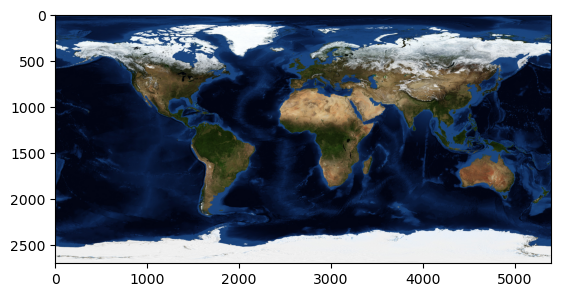

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import urllib

# Set image extent in degrees
img_extent = (-180, 180, -90, 90)

# Load image
img = plt.imread('images/nasa_blue_marble_topography_bathymetry_2004_11.jpg')
plt.imshow(img);

## Create cubic map
Once the cubic projection has been defined, and the map image has been loaded, the process is rather straightforward. One important aspect is setting the correct image size, such that the image has the correct size when printing it on sticker paper. The cutting lines where also extremely helpful and hardly noticeable when the cuts were made correctly.

In [ ]:
# Set dimensions corresponding to the Rubiks cube size
fig = plt.figure(figsize=(8.973, 6.73))

# Add subplot with the cubic projection
ax = fig.add_subplot(1, 1, 1, projection=rHEALPix(), frameon=False)

ax.set_global()

# Add image
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())

# Add vertical cutting lines
x_min, x_max = ax.get_xlim()
for x in np.arange(x_min, x_max, (x_max-x_min) / 12):
    ax.axvline(x, c='w', lw=0.1)

# Add horizontal cutting lines
y_min, y_max = ax.get_ylim()
for y in np.arange(y_min, y_max, (y_max-y_min) / 9):
    ax.axhline(y, c='w', lw=0.1)

# Save figure
# plt.savefig('earth_as_rubiks_cube.png', dpi=900, bbox_inches='tight', pad_inches=0)

## Photos of the creation process

Step 1: Clean Rubik's cube            |  Step 2: Print and cut map stickers
:------------------------------------:|:------------------------------------:
![](/images/rubiks_cube_clean.jpg)    |  ![](/images/rubiks_cube_cutouts.jpg)
Step 3: Apply stickers                |  Step 4: Enjoy a new world-view
![](/images/rubiks_cube_halfway.jpg)  |  ![](/images/earth_rubiks_final.jpg)

As pointed out by Kevin, this may just give rise to new theories among the flat-earth community...